<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

authors:
shoham zarfati - 318501418
hod twito - 315230482
ron zeidman - 315154864

# Data Loading

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [5]:
def reshape_data(data):
  images = list()
  for d in data:
      image = np.zeros((32,32,3), dtype=np.uint8)
      image[...,0] = np.reshape(d[:1024], (32,32)) # Red channel
      image[...,1] = np.reshape(d[1024:2048], (32,32)) # Green channel
      image[...,2] = np.reshape(d[2048:], (32,32)) # Blue channel
      images.append(image)
  return np.array(images)

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
import tarfile
import os

dev = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(dev[0], True)
print(tf.test.gpu_device_name())

def load_data():
  if not os.path.isdir('cifar-100-python'):
    data = requests.get("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")
    with open("cifar100.tar.gz", 'wb') as f:
        f.write(data.content) 

    tar = tarfile.open("cifar100.tar.gz", "r:gz")
    tar.extractall()
    tar.close()

  # loading the raw cifar100 data
  cifar_train = unpickle("cifar-100-python/train")
  cifar_test = unpickle("cifar-100-python/test")

  # extracting the training data.
  train_data = reshape_data(cifar_train[b'data'])
  train_labels = np.array(cifar_train[b'coarse_labels'])
  train_fine_labels = np.array(cifar_train[b'fine_labels'])

  # extracting the testing data
  test_data = reshape_data(cifar_test[b'data'])
  test_labels = np.array(cifar_test[b'coarse_labels'])
  test_fine_labels = np.array(cifar_test[b'fine_labels'])

  # extracting the kabek names
  meta = unpickle("cifar-100-python/meta")
  label_names = meta[b'coarse_label_names']
  fine_label_names = meta[b'fine_label_names']

  label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), label_names)))
  fine_label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), fine_label_names)))
  return train_data, test_data, train_labels, test_labels, train_fine_labels, test_fine_labels, label_names, fine_label_names

train_data, test_data, train_labels, test_labels, train_fine_labels, test_fine_labels, label_names, fine_label_names = load_data()

# Data Exploration

In [ ]:
import math
# plot a group of images in a grid, note: len(images) must be a square number
def plot_images(images, labels=None, fig_size=(10,10)):
  size = int(math.sqrt(len(images)))
  fig, aux = plt.subplots(size, size, figsize=fig_size)
  aux = aux.flatten()
  for i in range(0,aux.size):
    aux[i].imshow(images[i])
    if labels is not None:
      aux[i].title.set_text(labels[i])

In [ ]:
def get_label_name(label_id):
  return fine_label_names[label_id]

def get_label_id(label_name):
  return np.where(fine_label_names == label_name)[0][0]

The dataset is split into two sets, training data and test data. All images are 32x32 with RGB color channals. There are 2 types of labels, "high level" categories of which there are 20, and "low level" categories of which there are 100. Each of the 100 low level categories belongs to a high level category. We start by observing the number of samples in each set, and the distribution of labels.

number of high level labels: 20
number of low level labels: 100
number of training imeges: 50000
number of testing imeges: 10000
image shape: (32, 32, 3)


<BarContainer object of 100 artists>

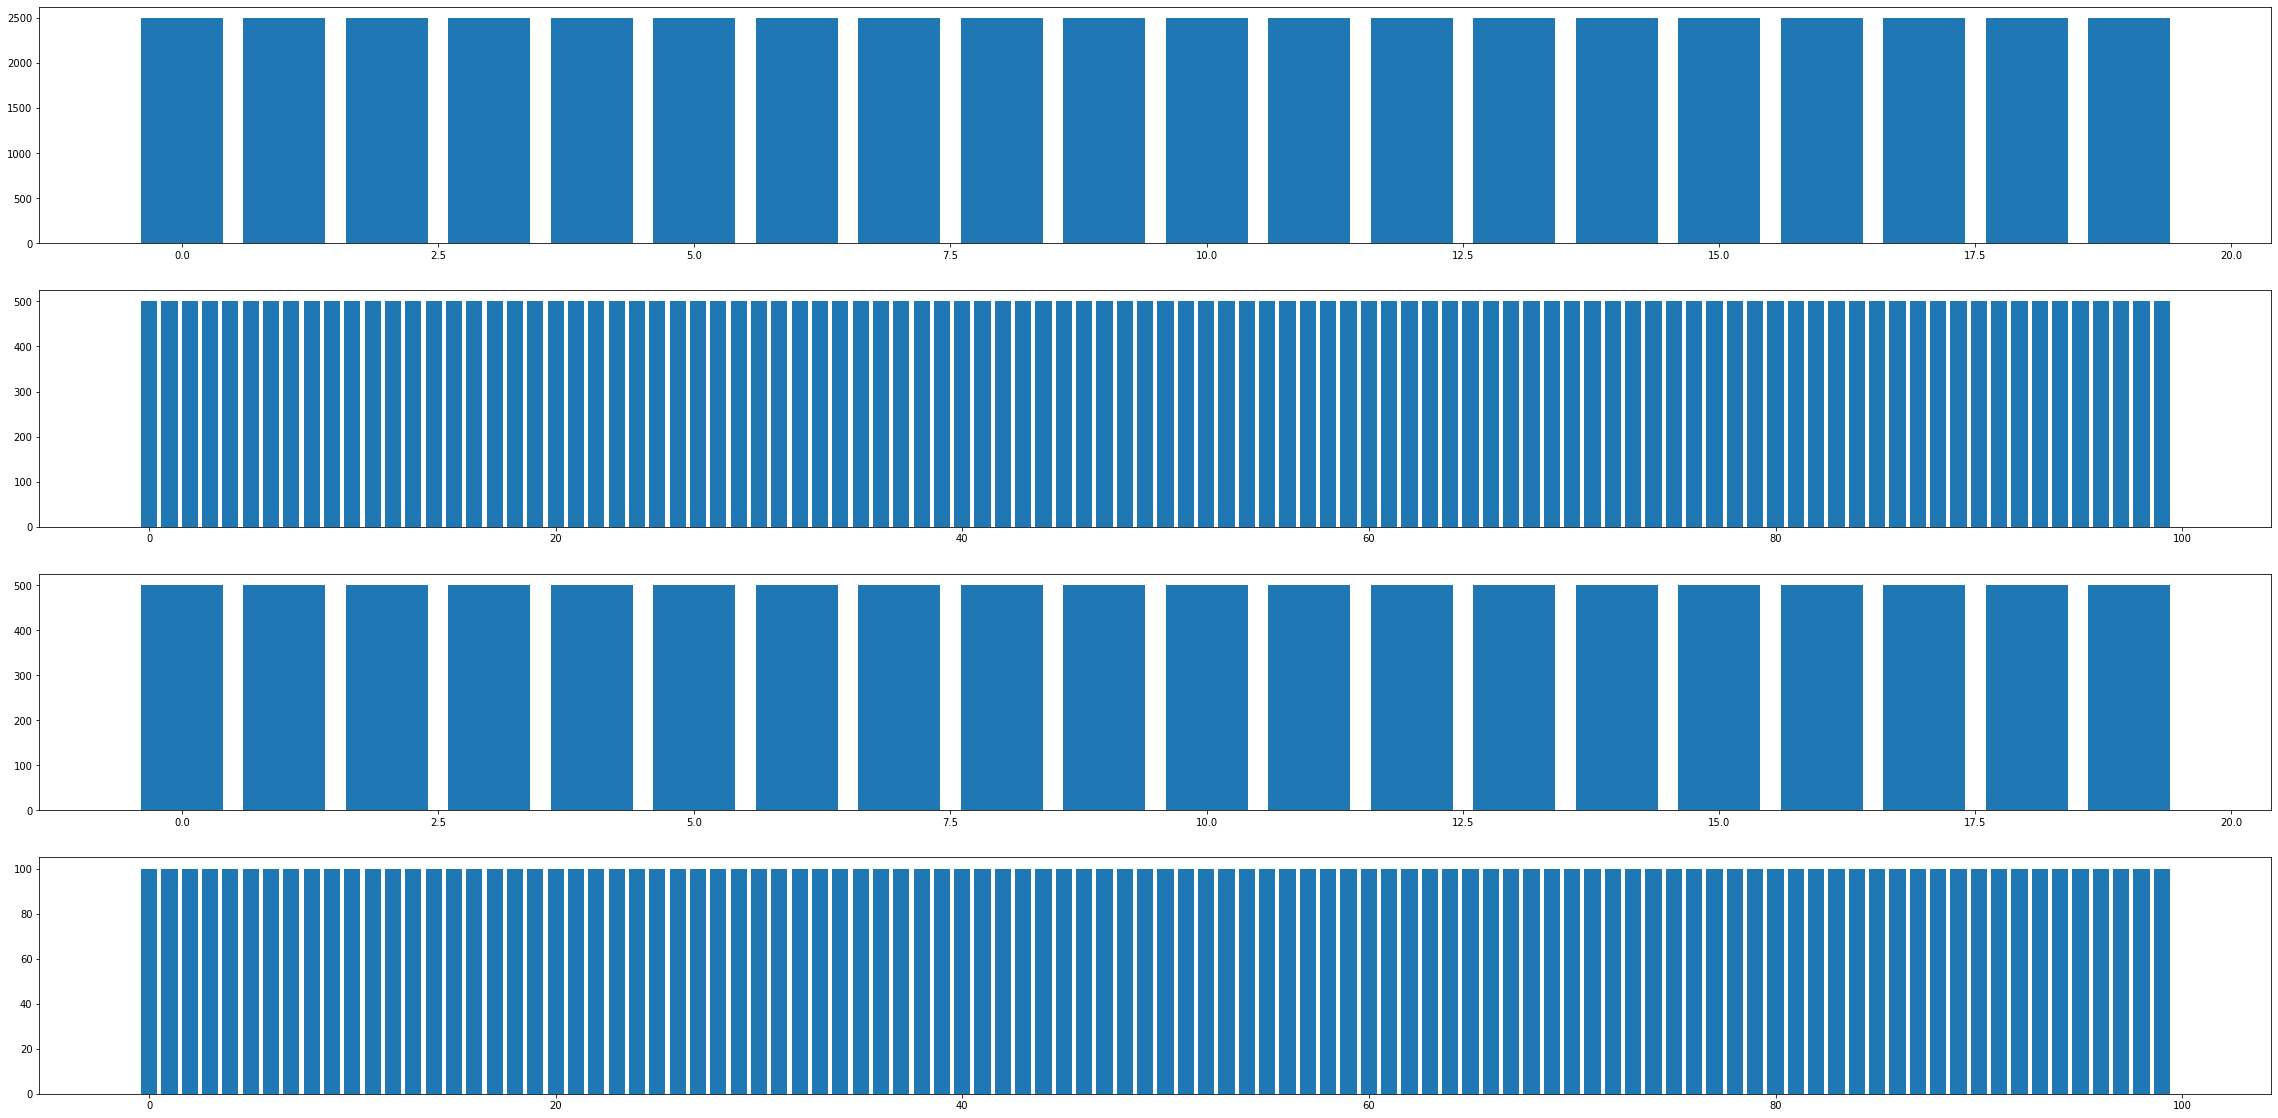

In [ ]:
print("number of high level labels: " + str(label_names.size))
print("number of low level labels: " + str(fine_label_names.size))

print("number of training imeges: " + str(len(train_data)))
print("number of testing imeges: " + str(len(test_data)))

print("image shape: " + str(train_data[0].shape))

train_lbl, train_lbl_counts = np.unique(train_labels, return_counts=True)
train_fine_lbl, train_fine_lbl_counts = np.unique(train_fine_labels, return_counts=True)

test_lbl, test_lbl_counts = np.unique(test_labels, return_counts=True)
test_fine_lbl, test_fine_lbl_counts = np.unique(test_fine_labels, return_counts=True)

fig, aux = plt.subplots(4, figsize=(40,20))
aux[0].bar(train_lbl, train_lbl_counts, label="training high level label distribution")
aux[1].bar(train_fine_lbl, train_fine_lbl_counts, label="training low level label distribution")
aux[2].bar(test_lbl, test_lbl_counts, label="testing high level label distribution")
aux[3].bar(test_fine_lbl, test_fine_lbl_counts, label="testing low level label distribution")


As we can see from the plots above, the label distribution in the data is perfectly uniform, each high level label having 2500 training examples and 500 testing examples, while each low level label has 500 training examples and 100 testing examples.

Next Lets take a look at the labels and images themselves. First we show an example of 25 images with their labels. We can immediatly see two things:
 * The big veriaty of images and labels available
 * How liitle image data available for each image, many images are bearly recognizable even to humans.

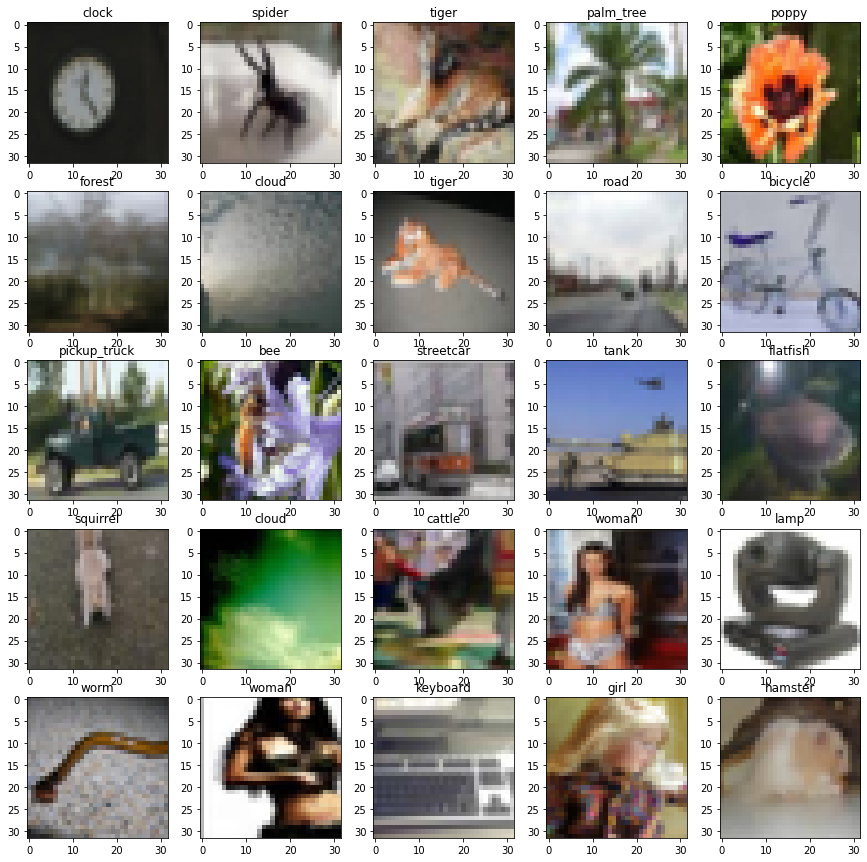

In [ ]:
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

Next lets take a look at the labels we are going to use (we'll only use the low level labels for our models)

In [ ]:
print(fine_label_names)

['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin'
 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo'
 'keyboard' 'lamp' 'lawn_mower' 'leopard' 'lion' 'lizard' 'lobster' 'man'
 'maple_tree' 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oak_tree'
 'orange' 'orchid' 'otter' 'palm_tree' 'pear' 'pickup_truck' 'pine_tree'
 'plain' 'plate' 'poppy' 'porcupine' 'possum' 'rabbit' 'raccoon' 'ray'
 'road' 'rocket' 'rose' 'sea' 'seal' 'shark' 'shrew' 'skunk' 'skyscraper'
 'snail' 'snake' 'spider' 'squirrel' 'streetcar' 'sunflower'
 'sweet_pepper' 'table' 'tank' 'telephone' 'television' 'tiger' 'tractor'
 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale' 'willow_tree' 'wolf'
 'woman' 'worm']


obviously some labels are more similar then others, lets take a look at some examples.

In [ ]:
def get_label_examples(data, label, size=10):
  lbl_indx = np.arange(len(train_fine_labels))
  lbl_filter = train_fine_labels == get_label_id(label)
  indecies = np.random.choice(lbl_indx[lbl_filter], size, replace=False)
  return data[indecies]

Here we see some images of apples and lions ( two apples above and two lions below), though some images are a little hard to identify, the two classes are easily seprebale.

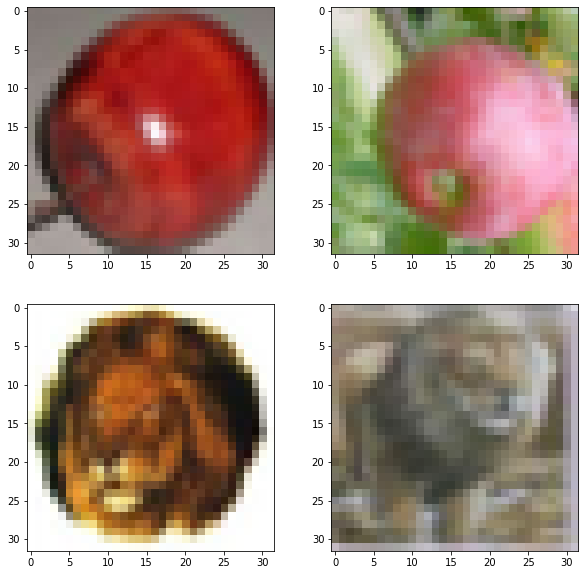

In [ ]:
apple_examples = get_label_examples(train_data, 'apple', size=2)
bee_examples = get_label_examples(train_data, 'lion', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

Here we see some images of willow trees and oak trees ( two willow trees above and two oak trees below), Those are much harder to seperate, expecially with the very low resultion of the images

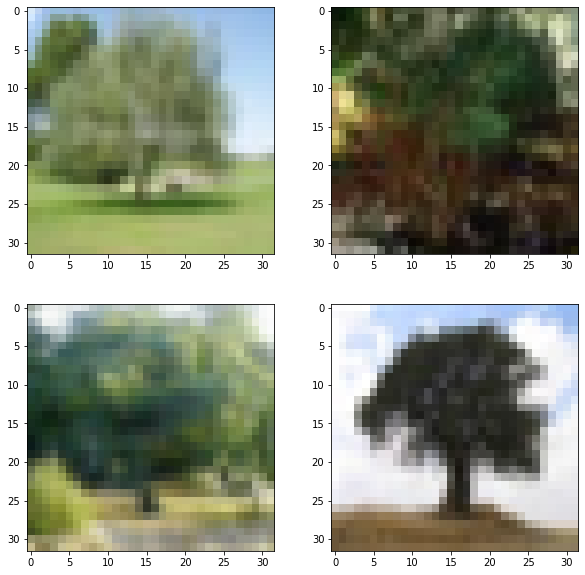

In [ ]:
apple_examples = get_label_examples(train_data, 'willow_tree', size=2)
bee_examples = get_label_examples(train_data, 'oak_tree', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

After seeing the data, we can start preparing it for use in our models. sience we are going to be using neural networks, the data should be in the (0-1) range, so we'll start by normalizing the data by deviding all the integer values by 255. We plot 25 random images again to make sure that the images are preserved after the normalization.

72344

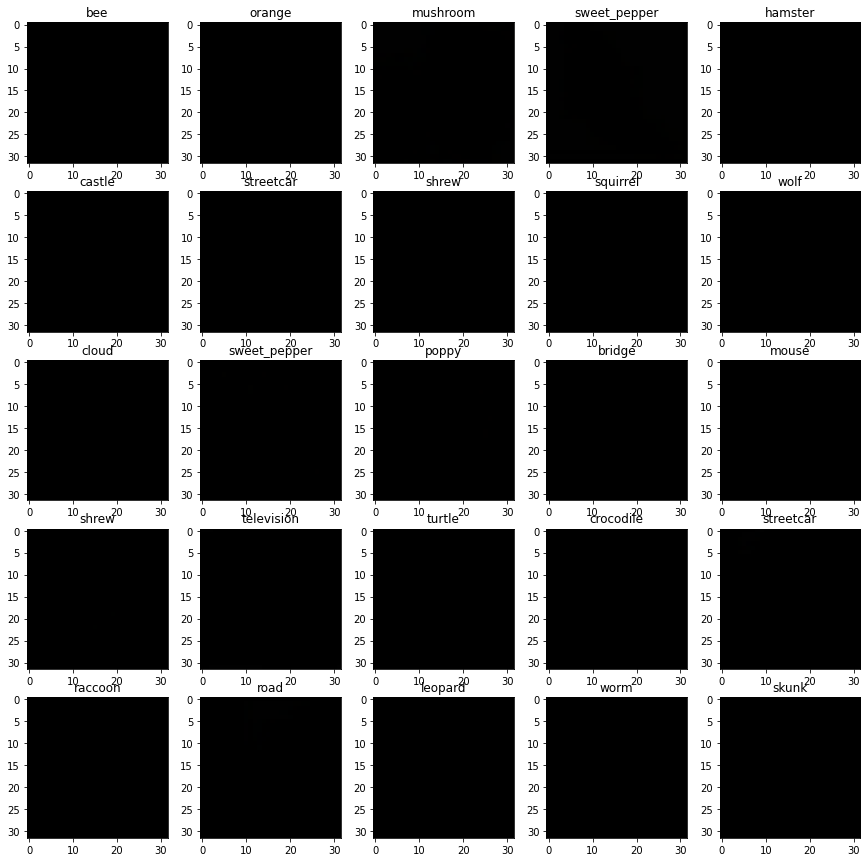

In [ ]:
import gc

train_data = train_data.astype(np.float32) / 255
test_data = test_data.astype(np.float32) / 255
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

gc.collect()

Next is data augmentation, We try three different modes of augmentation:
* in place - meaning we augment some of the images in the training data to increase variance.
* addition - we increase the size of the training data by creating variations of the images we have.
* non - we try to use the original data with no augmentation.

The kinds of augmentations we use are as follows:

* Crop - small crops preserving image size, should not affect the image label
* GaussianNoise - adding small noise to the image will also not affect it but will increase the variance of the data.
* Flip - we add the flipped images to the training data, there are no labels that can be affected by flipping and such an augmantation could generates more general knowladge of the label.
* Transform - we add the transformed image to the training data, sometimes moving the image a few pixels along the y axis, and sometimes moving it along the x axis.
* Brightness - we change the image brightness a little adding the changed image to the training data, this should not change any labels as the brighness change is not big enough to obscure the data.
* Rotate - we add the rotated image to the training data, the rotation is up to 45 degrees, and thus is not enough to change the image label.

After applying the addition augmentation we shuffle the training data in order to no have a clear seperation between the orignial and augmented images.

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia

aug_inplace = iaa.Sequential([
    iaa.Sometimes(0.2, iaa.Crop(px=(1, 4), keep_size=True)),
    iaa.AdditiveGaussianNoise()
])

def aug_add(data, labels, shuffle=True):

  flip = iaa.Fliplr(1.0)

  trans = iaa.OneOf([
      iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, mode="edge"),
      iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, mode="edge")
  ])

  bor = iaa.OneOf([
      iaa.Add((-0.2, 0.2)),
      iaa.Affine(rotate=(-45, 45), mode="edge")
  ])

  cp_1 = np.copy(data)
  cp_2 = np.copy(data)
  cp_3 = np.copy(data)

  if shuffle:
    aug_data = np.concatenate((data, flip(images=cp_1), trans(images=cp_2), bor(images=cp_3)))
    aug_labels = np.concatenate((labels, labels, labels, labels))
    # we use the same seed before the suffles to achive the same order 
    # in the data and the labels.
    np.random.seed(400)
    np.random.shuffle(aug_data)
    np.random.seed(400)
    np.random.shuffle(aug_labels)
  else:
    aug_data = np.stack((data, flip(images=cp_1), trans(images=cp_2), bor(images=cp_3)))
    aug_labels = np.stack((labels, labels, labels, labels))

  return aug_data, aug_labels


def infrence_time_aug(data):
  flip = iaa.Fliplr(1.0)
  cp_1 = np.copy(data)
  aug_data = np.stack((data, flip(images=cp_1)))
  return aug_data

Before we build our own model it might be a good idea to look at the state of the art methods of solving this problem. A good place to do that is here https://paperswithcode.com/sota/image-classification-on-cifar-100. We can see that the SOTA accuracy in this problem is very high, and most if not all of the solutions use CNN arcitectures. The top solutions use very deep architectures using residual connections and wide bloks.

We use wandb.com to log our model progression, visit https://wandb.ai/zshoham/dl_assignment1 for full log of our models performance.

In [9]:
!pip install wandb -qqq
import wandb
!wandb login

     |████████████████████████████████| 1.8MB 5.3MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 163kB 21.6MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 133kB 17.7MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import gc

def log_metrics(model, scores, data, probabilaties, labels):
    for i in range(0, len(scores)):
      print(f'Score : test_{model.metrics_names[i]} of {scores[i]}')
      wandb.log({f'test_{model.metrics_names[i]}': scores[i]}, commit=False)

    prob_max = np.amax(probabilaties, axis=1)
    predictions = np.argmax(probabilaties, axis=1)
    pr = precision_score(labels, predictions , average="macro")
    rc = recall_score(labels, predictions , average="macro")
    f1 = f1_score(labels, predictions , average="macro")
    wandb.log({"precision": pr, "recall": rc, "f1": f1}, commit=False)

    certain = np.argmax(prob_max, axis=0)
    uncertain = np.argmin(prob_max, axis=0)

    # we apply f(x)=-x to all the correct predictions, so that we will
    # get the maximum of the incerrect predictions when using armax
    wrong_preds = np.piecewise(prob_max, predictions == labels, [lambda x: -x, lambda x: x])
    certain_wrong = np.argmax(wrong_preds, axis=0)
    
    fig_certain, aux_certain = plt.subplots()
    aux_certain.imshow(data[certain])
    aux_certain.title.set_text("pred - " + get_label_name(predictions[certain]) +
                            " / true - " + get_label_name(labels[certain]) +
                            " / prob=" + str(prob_max[certain]))

    fig_uncertain, aux_uncertain = plt.subplots()
    aux_uncertain.imshow(data[uncertain])
    aux_uncertain.title.set_text("pred - " + get_label_name(predictions[uncertain]) +
                             " / true - " + get_label_name(labels[uncertain]) +
                             " / prob=" + str(prob_max[uncertain]))
    
    fig_wrong_certain, aux_wrong_certain = plt.subplots()
    aux_wrong_certain.imshow(data[certain_wrong])
    aux_wrong_certain.title.set_text("pred - " + get_label_name(predictions[certain_wrong]) +
                             " / true - " + get_label_name(labels[certain_wrong]) +
                             " / prob=" + str(prob_max[certain_wrong]))
    
    wandb.log({"correct certain prediction": fig_certain,
               "wrong certain prediction": fig_wrong_certain,
               "uncertain prediction": fig_uncertain})

def evaluate(model_gen, group_name, arch_name, aug_type, trin_data, train_labels, ita=False):
  acc_per_fold = []
  loss_per_fold = []
  
  wandb_run_name = arch_name + "-" + aug_type
  if ita:
    wandb_run_name = wandb_run_name + "-ita" 

  wandb_config = {
      "data_augmentation": aug_type,
      "epochs": 30,
      "batch_size": 100,  
      "architecture": arch_name,
  }

  data = np.concatenate((trin_data, test_data), axis=0)
  labels = np.concatenate((train_labels, test_fine_labels), axis=0)
  kfold = KFold(n_splits=5, shuffle=True)
  fold_num = 5
  for train, test in kfold.split(data, labels):
    wandb.init(
      project="dl_assignment1",
      group=group_name,
      name=wandb_run_name +  "-" + str(fold_num),
      config=wandb_config)
    config = wandb.config
    model = model_gen()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gc.collect()

    history = model.fit(data[train], labels[train],
              batch_size=config.batch_size,
              epochs=config.epochs,
              verbose=2,
              validation_split=0.1,
              callbacks=[WandbCallback()])
    
    gc.collect()
    # model eval
    if not ita:
      scores = model.evaluate(data[test], labels[test], verbose=0)
      pred_probs = model.predict(data[test])
      log_metrics(model, scores, data[test], pred_probs, labels[test])
    else:
      aug_test_data = infrence_time_aug(data[test])
      # stack the predictions of each augmentation
      aug_pred_probs = np.stack([model.predict(aug) for aug in aug_test_data])
      # average the predictions probabilities between the augmentations
      mean_pred_probs = np.mean(aug_pred_probs, axis=0)
      scores = model.evaluate(data[test], labels[test], verbose=0)
      aug_preds = np.argmax(mean_pred_probs, axis=1)
      scores[1] = np.mean(aug_preds == labels[test])
      log_metrics(model, scores, data[test], mean_pred_probs, labels[test])
      gc.collect()
    wandb.finish()

    # finish fold
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_num = fold_num + 1
  
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

# Shallow CNN

In [ ]:
model_gen = lambda: keras.Sequential(
    [
      keras.Input((32,32,3)),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dense(100, activation='softmax')
    ]
)

evaluate(model_gen, "custom_model", "shallow_cnn", "no-aug", train_data, train_fine_labels)
evaluate(model_gen, "custom_model", "shallow_cnn", "inplace", aug_inplace(images=train_data), train_fine_labels)

This model doesnt perform very well even with the inplace augmentation, we can also see that it couses segnificant overfitting. We suggest three ways to improve the performance:
* Increasing the size of the training data with augmentation.
* Improving the model, making it deeper and able to learn better.
* Changin hyperparameters to achive better training.

We have implemented the first two suggestions, mainly because hyperparameter optimization requires a lot of time to run the models again and again, and of course a lot of computation power to run the models for so long, both of which we are short on.  

In [ ]:
aug_train_data, aug_train_fine_labels = aug_add(train_data, train_fine_labels)
evaluate(model_gen, "custom_model", "shallow_cnn", "add", aug_train_data, aug_train_fine_labels)

We can see from the results that using this augmentation does indeed improve the performance segnificantly, to see the full report of this models performance see https://wandb.ai/zshoham/dl_assignment1/reports/Shallow-CNN-Report--VmlldzozMzIxMzA

# Deep CNN

In [ ]:
model_gen = lambda: keras.Sequential(
    [
      keras.Input((32,32,3)),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.1),
      layers.MaxPool2D(),
      layers.Conv2D(32, 1, activation='relu'),
      layers.Conv2D(128, 3, activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(),
      layers.Conv2D(128, 3, activation='relu'),
      layers.BatchNormalization(),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dropout(0.25),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(100, activation='softmax')
    ]
)

evaluate(model_gen, "custom_model", "deep_cnn", "no-aug", train_data, train_fine_labels)
aug_train_data, aug_train_fine_labels = aug_add(train_data, train_fine_labels)
evaluate(model_gen, "custom_model", "deep_cnn", "add", aug_train_data, aug_train_fine_labels)

Because we saw no improvment from the inplace augmentation, we are only try no augmentation and add augmentation.
We can see from the results that even without augmentation the deeper model outperforms the shallow one even when the shallow model uses add augmentation, and of curse we see that the model doesnt cause overfitting anymore.
When using the add augmentation with this model, we achive very good results up to 0.64 in the test set.

Lastly we try to use infrence time augmentation with this model. sience we saw that training augmentation consistantly improves performance we are not going to try to run the model without augmentation. A few points on our implementation:
* We only perform the augmentation on the test set meaning the model trains as if it does not exist.
* We run the model on each augmentation of the test set and then average the results to get the final output.
* We use only one augmentation - Flip because of the ram constraints we have in colab. (we tried using 3 augmentations like in our training data, but there wasn't enough RAM to hold the data)


In [ ]:
evaluate(model_gen, "custom_model", "deep_cnn", "add", aug_train_data, aug_train_fine_labels, ita=True)

We can see that the infrence time augmentation improves the results even further, and we might have been able to see even better with more augmentations.
To see the full report for this model see https://wandb.ai/zshoham/dl_assignment1/reports/Deep-CNN-Report--VmlldzozMzI3MTk

#Fine Tuning - EfficientNet-B0

We chose to fine tune the EfficientNet-B0 as it is relativly simple and powerfull. First we re-load the data from the disk becuase the EfficientNet arcitecture requires the data to be in a different format than our models.

In [ ]:
train_data, test_data, train_labels, test_labels, train_fine_labels, test_fine_labels, label_names, fine_label_names = load_data()

We load the EfficientNetB0 model from keras.applications, not including the infrence layers.
EfficientNetB0 expects 224x224 images with RGB color, because our images are smaller (32x32) we added a Resizing layer after the input, scaling the images to the format EfficientNetB0 expects. After the EfficientNetB0 convolution layers we added GlobalAverageMaxPooling to scale down the data, and later BatchNorm and Dropout to improve the training and reduce overfitting. Lastly we added our infrence layer with 100 outputs.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def model_gen():
  core = EfficientNetB0(include_top=False, input_shape=(224,224,3), classes=100)

  core.trainable = False

  input = keras.Input(shape=(32, 32, 3))
  x = layers.experimental.preprocessing.Resizing(224, 224)(input)

  x = core(x, training=False)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(100, activation="softmax")(x)
  model = tf.keras.Model(input, outputs, name="EfficientNet")

  return model

In [ ]:
model = model_gen()
model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_8 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

Before starting the training we need to preprocess the data to fit the Efficientnetb0's expectations, keras provides a function to preprocess the data corectly.

In [ ]:
proc_data = tf.keras.applications.efficientnet.preprocess_input(train_data)
evaluate(model_gen, "sota_model", "effnetb0", "no-aug", proc_data, train_fine_labels)

aug_train_data, aug_train_fine_labels = aug_add(train_data, train_fine_labels)
proc_data = tf.keras.applications.efficientnet.preprocess_input(aug_train_data)
evaluate(model_gen, "sota_model", "effnetb0", "add", proc_data, aug_train_fine_labels, ita=True)

We first trained the model with no augmentations to see how a baseline would look, and later we trained the model using both add augmentation and the infrence time augmentation.

To see the results we got see https://wandb.ai/zshoham/dl_assignment1/reports/Efficientnetb0-Report--VmlldzozMzU1MDA

# Calssical ML

Finally we try to use the EfficientNetB0 model as a feature extractor, removing the last FC layer in otder to use the learned embedding in a classical classifier.

In [10]:
train_data, test_data, train_labels, test_labels, train_fine_labels, test_fine_labels, label_names, fine_label_names = load_data()

We load one of the EfficientNetB0 we fine tuned, specifically [this](https://wandb.ai/zshoham/dl_assignment1/runs/3gfg0uge?workspace=user-zshoham) one. This was our best performing model.

In [11]:
from tensorflow.keras.models import load_model
best_model = load_model(wandb.restore("model-best.h5", run_path="/zshoham/dl_assignment1/3gfg0uge").name)
effnet_out = best_model.layers[-3].output
feature_extractor = tf.keras.Model(best_model.input, effnet_out, name="EfficientNet")
feature_extractor.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_5 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1280)              5120      
Total params: 4,054,691
Trainable params: 2,560
Non-trainable params: 4,052,131
_________________________________________________________________


We use the model we loaded to create the embedings for our training and test data.

In [ ]:
effnet_test_embedings = feature_extractor.predict(test_data)
effnet_train_embedings = feature_extractor.predict(train_data)

Then we trein a linear SVM model with the embedings we created.

In [ ]:
from sklearn.svm import SVC

classifier = SVC(kernel="linear")
classifier.fit(effnet_train_embedings, train_fine_labels)

In [ ]:
predictions = classifier.predict(effnet_test_embedings)

In [ ]:
acc = np.mean(predictions == test_fine_labels)
print("SVM test accuracy:" + str(acc))

We can see the svm model can achieve very good results as the classifier using the embedings created by the convolution layers.

For a table with all of our runs https://wandb.ai/zshoham/dl_assignment1/table?workspace=user-zshoham